In [ ]:
# Machine Learning Models from the RealEstate database built and modeled in SQL (((RentalMarket)))

# This was done prior to feature engineering for Sales and Rental market, further ML/EDA will be done on TX alone

In [46]:
import numpy as np
import pandas as pd 
from pandas import Series, DataFrame
import re
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pyodbc.drivers()

['SQL Server',
 'SQL Server Native Client 11.0',
 'SQL Server Native Client RDA 11.0',
 'ODBC Driver 17 for SQL Server']

In [3]:
cnxn_str = (
    r'DRIVER=SQL Server;'
    r'SERVER=(local)\MSSQLSERVER01;'
    r'Trusted_Connection=yes;'
    r'Database=RealEstate'
    #r'AttachedDbFileName=D:\SQL2019\MSSQLSERVER01\MSSQL\DATA\RealEstate.mdf;'
)
cnxn = pyodbc.connect(cnxn_str)
#df = pd.read_sql("SELECT * FROM sys.databases", cnxn)
#df

In [20]:
# DataFrames defined by Live TSQL Queries

RentalRates_Window = pd.read_sql("SELECT * FROM RentalRates_Window", cnxn)

#RentalRates_UnPiv = pd.read_sql("SELECT * FROM RentalRatesUnPiv", cnxn)

In [23]:
RentalRates_Window.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9419 entries, 0 to 9418
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Lstate         9419 non-null   object 
 1   CityName       9419 non-null   object 
 2   Date           9419 non-null   object 
 3   Value          9419 non-null   int64  
 4   PriorMonth     9378 non-null   float64
 5   DiffPrevMonth  9378 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 441.6+ KB


In [24]:
RentalRates_Window # Additional Features (60,90,120 day change, avg mortgage in same area[top/bottom tier])

,Lstate,CityName,Date,Value,PriorMonth,DiffPrevMonth
0,AL,Birmingham,2014-01-01,924,NaN,NaN
1,AL,Birmingham,2014-02-01,944,924.0,20.0
2,AL,Birmingham,2014-03-01,937,944.0,-7.0
3,AL,Birmingham,2014-04-01,935,937.0,-2.0
4,AL,Birmingham,2014-05-01,937,935.0,2.0
...,...,...,...,...,...,...
9414,WI,Milwaukee,2021-03-01,1196,1346.0,-150.0
9415,WI,Milwaukee,2021-04-01,1205,1196.0,9.0
9416,WI,Madison,2021-04-01,1349,1205.0,144.0
9417,WI,Madison,2021-05-01,1350,1349.0,1.0


In [29]:
RentalRates_Window['Lstate'].value_counts()


FL               890
CA               890
OH               621
TX               445
NC               445
CO               445
NY               445
PA               439
TN               354
UT               267
CT               267
MA               267
SC               266
GA               265
LA               178
MO               178
AZ               178
WA               178
MI               178
OK               178
WI               178
VA               177
DC                89
MS                89
RI                89
MD                89
NM                89
AR                89
NE                89
HI                89
IN                89
OR                89
United States     89
IL                89
NV                89
ID                89
AL                89
IA                89
MN                89
KY                89
KS                88
Name: Lstate, dtype: int64

In [38]:
RentalRates_Window['Lstate'].value_counts()

FL               890
CA               890
OH               621
TX               445
NC               445
CO               445
NY               445
PA               439
TN               354
UT               267
CT               267
MA               267
SC               266
GA               265
LA               178
MO               178
AZ               178
WA               178
MI               178
OK               178
WI               178
VA               177
DC                89
MS                89
RI                89
MD                89
NM                89
AR                89
NE                89
HI                89
IN                89
OR                89
United States     89
IL                89
NV                89
ID                89
AL                89
IA                89
MN                89
KY                89
KS                88
Name: Lstate, dtype: int64

In [55]:
RentalRates_Window['Lstate']

SyntaxError: invalid syntax (<ipython-input-55-e8d2c23735c0>, line 1)

<AxesSubplot:xlabel='Lstate', ylabel='Value'>

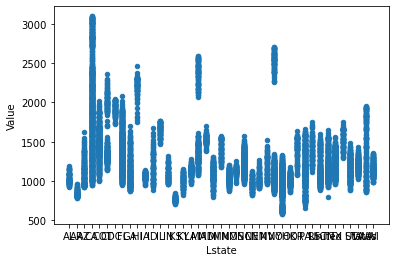

In [33]:
# use this to make a scatterplot of the features.
RentalRates_Window.plot(kind='scatter',x='Lstate', y='Value') 

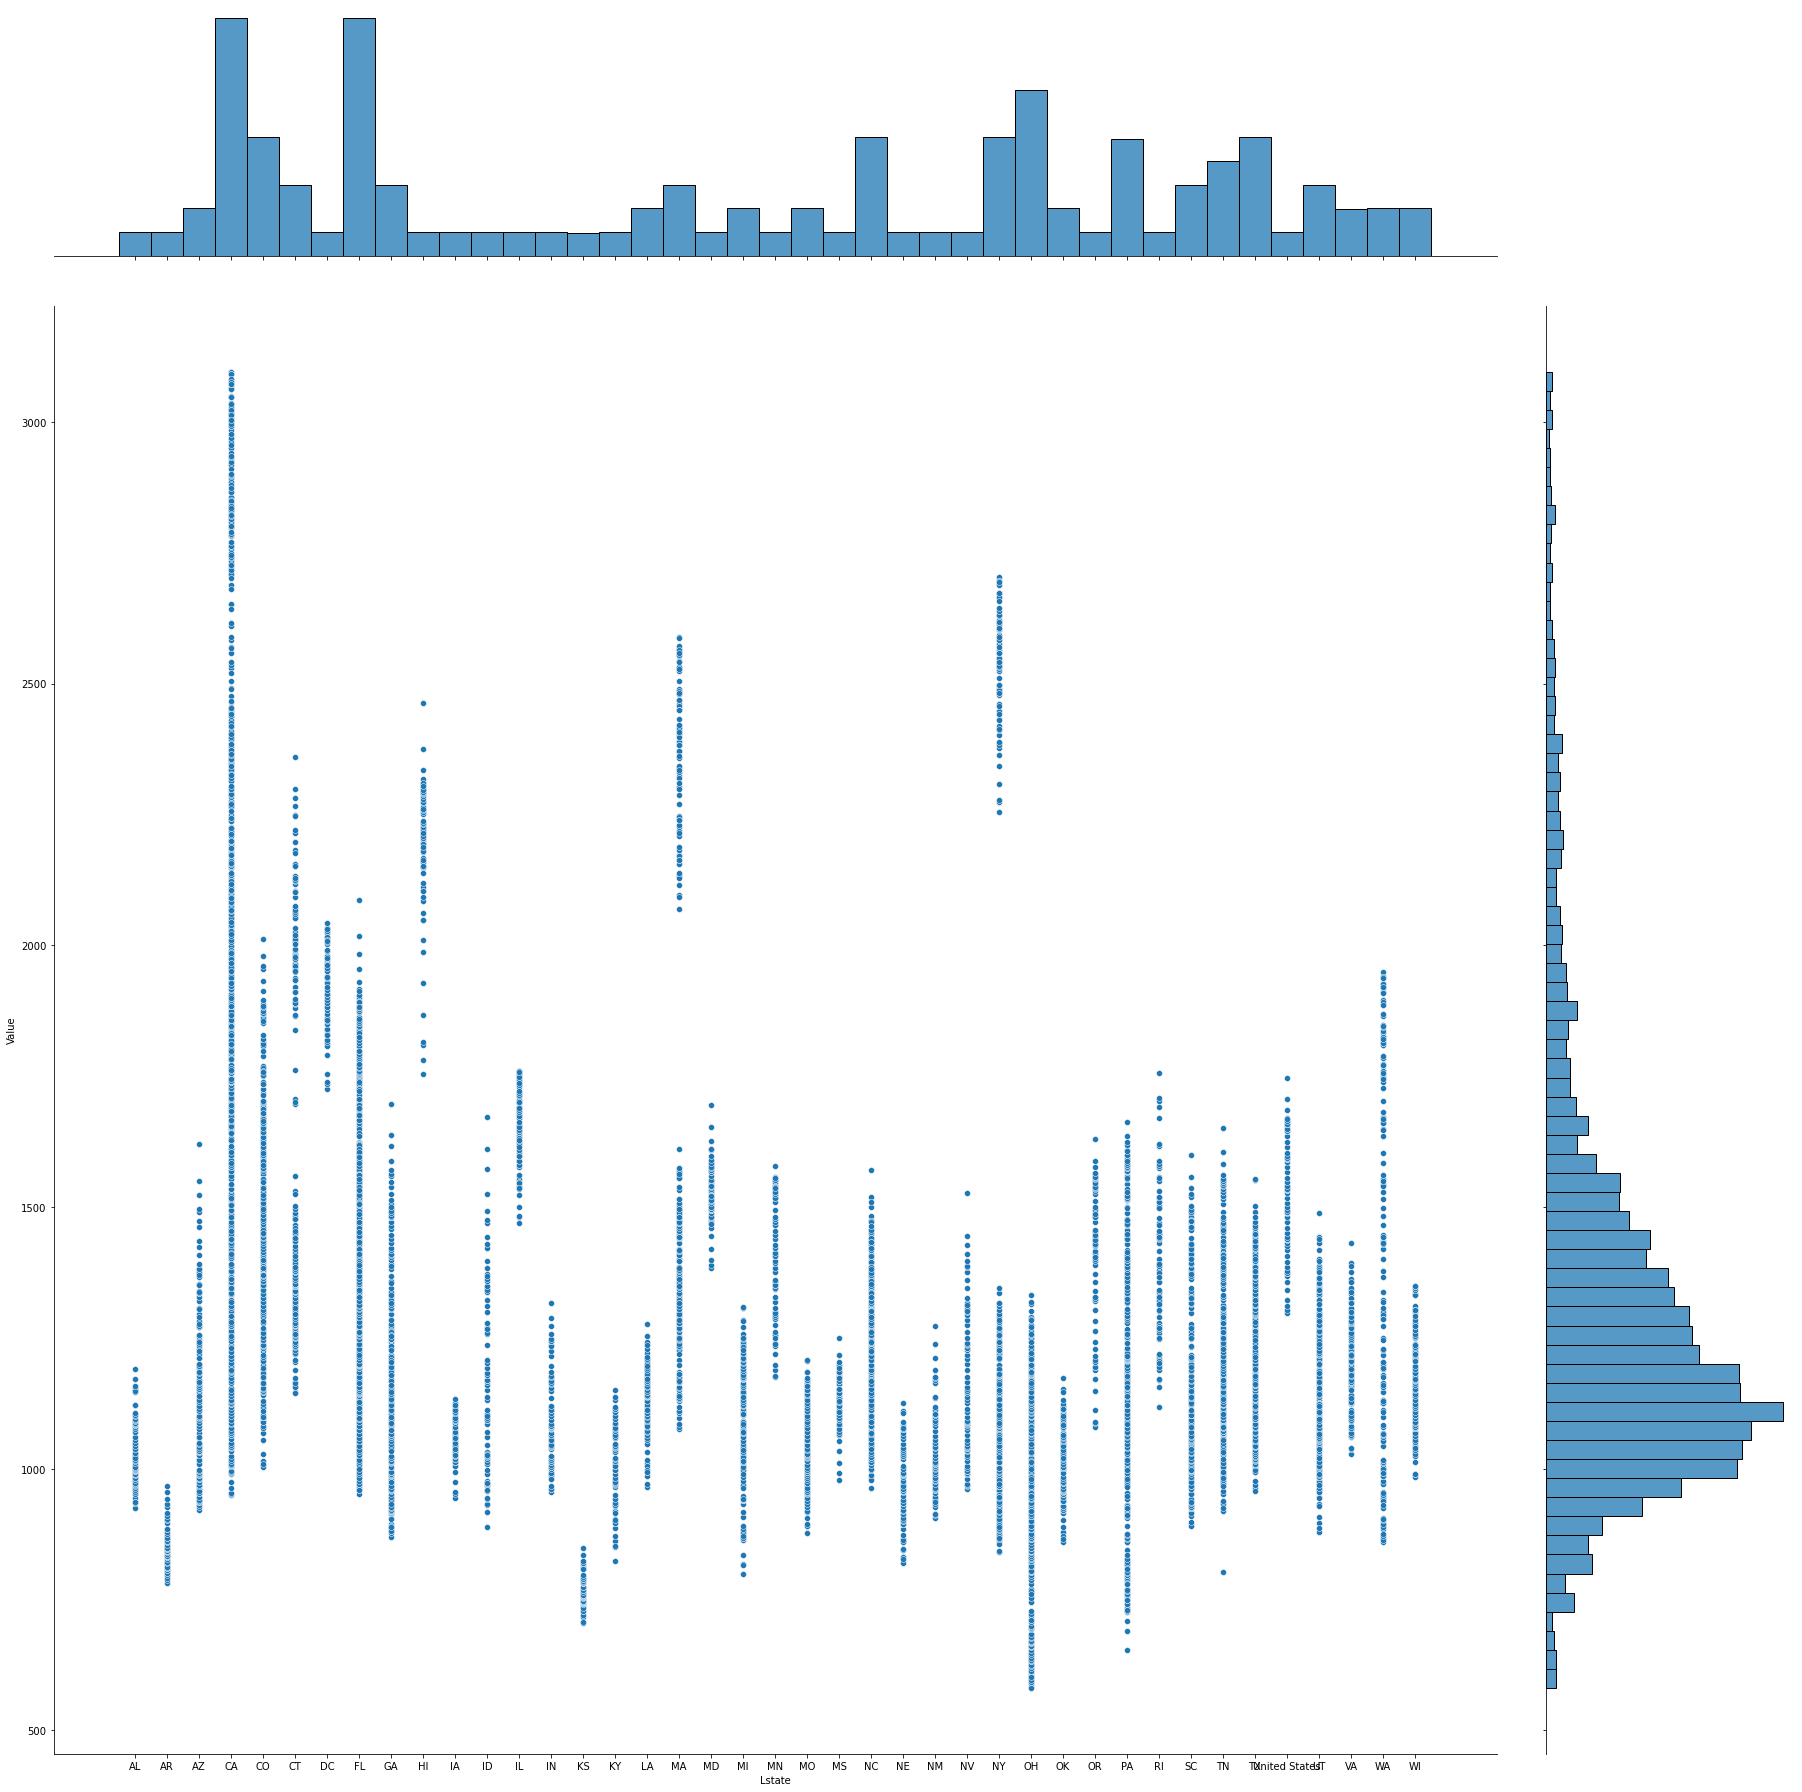

In [57]:
# A seaborn jointplot shows bivariate scatterplots and univariate histograms in the same figure
sns.jointplot(x='Lstate',y='Value', data=RentalRates_Window, height=25)

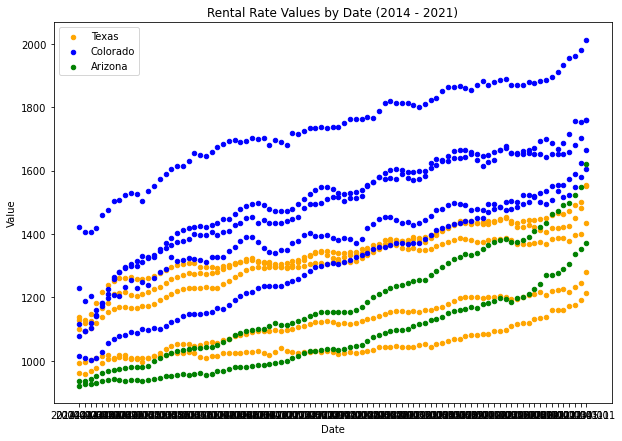

In [59]:
fig = RentalRates_Window[RentalRates_Window.Lstate == 'TX'].plot(kind='scatter', x='Date', y='Value', color='orange', label='Texas')
RentalRates_Window[RentalRates_Window.Lstate == 'CO'].plot(kind='scatter', x='Date', y='Value', color='blue', label='Colorado', ax=fig)
RentalRates_Window[RentalRates_Window.Lstate == 'AZ'].plot(kind='scatter', x='Date', y='Value', color='green', label='Arizona', ax=fig)

fig.set_xlabel('Date')
fig.set_ylabel('Value')
fig.set_title('Rental Rate Values by Date (2014 - 2021)')

fig=plt.gcf()
fig.set_size_inches(10, 7)
plt.show()

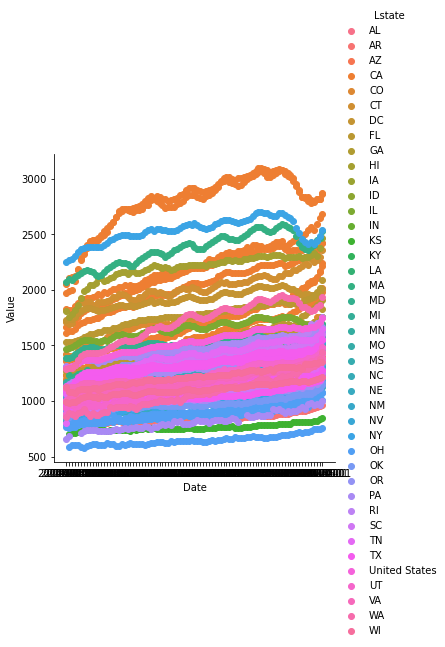

In [62]:
# use seaborn's FacetGrid to color the scatterplot by "Lstate"
sns.FacetGrid(RentalRates_Window, hue = 'Lstate', height=5) \
    .map(plt.scatter, 'Date','Value') \
    .add_legend()

<AxesSubplot:xlabel='Date', ylabel='Value'>

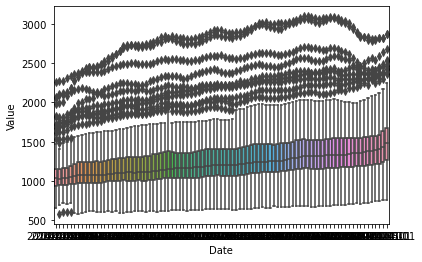

In [63]:
# We can look at an individual feature in Seaborn through a boxplot
sns.boxplot(x='Date', y='Value', data=RentalRates_Window)

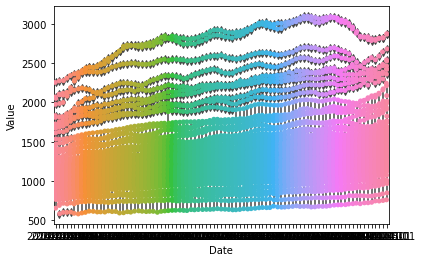

In [65]:
# One way we can extend this plot is adding a layer of individual points on top of
# it through Seaborn's striplot
# 
# use jitter=True so that all the points don't fall in single vertical lines
# above the species
#
# Saving the resulting axes as ax each time causes the resulting plot to be shown
# on top of the previous axes
ax = sns.boxplot(data=RentalRates_Window, x = 'Date',y = 'Value')
ax = sns.stripplot(data=RentalRates_Window, x='Date', y='Value', jitter=True, edgecolor='green')

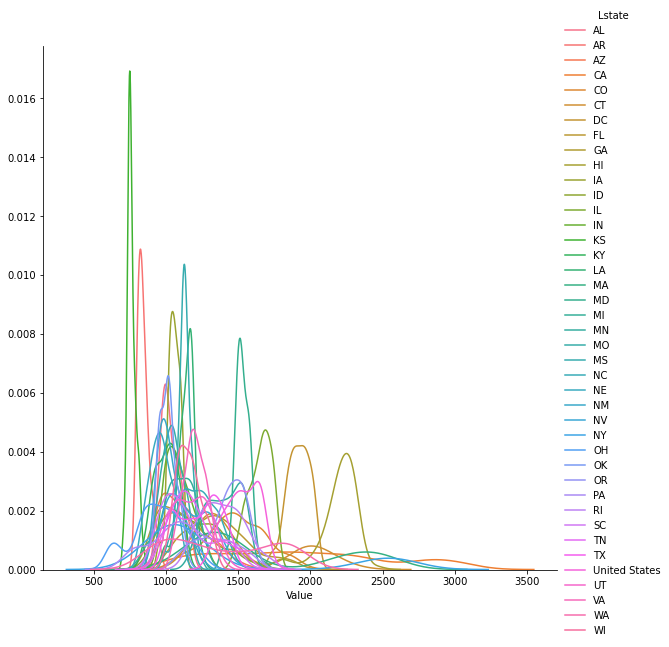

In [67]:
# A useful seaborn plot for looking at univariate relations is the kdeplot,
# which creates and visualizes a kernel density estimate of the underlying feature

sns.FacetGrid(RentalRates_Window, hue="Lstate", height=8) \
   .map(sns.kdeplot, "Value") \
   .add_legend()

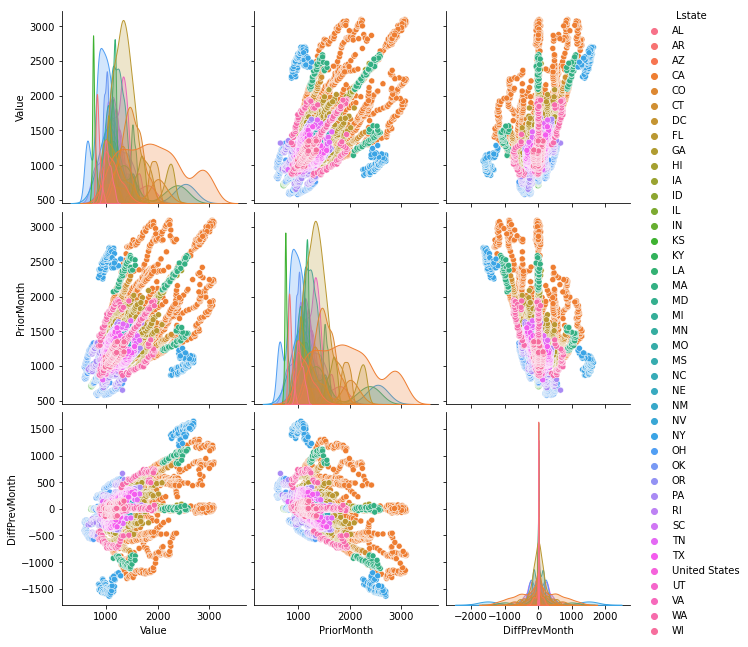

In [70]:
# sns.pairplot(RentalRates_Window.drop('Id', axis=1), hue='Value', size=3)

sns.pairplot(RentalRates_Window, hue='Lstate', height=3)

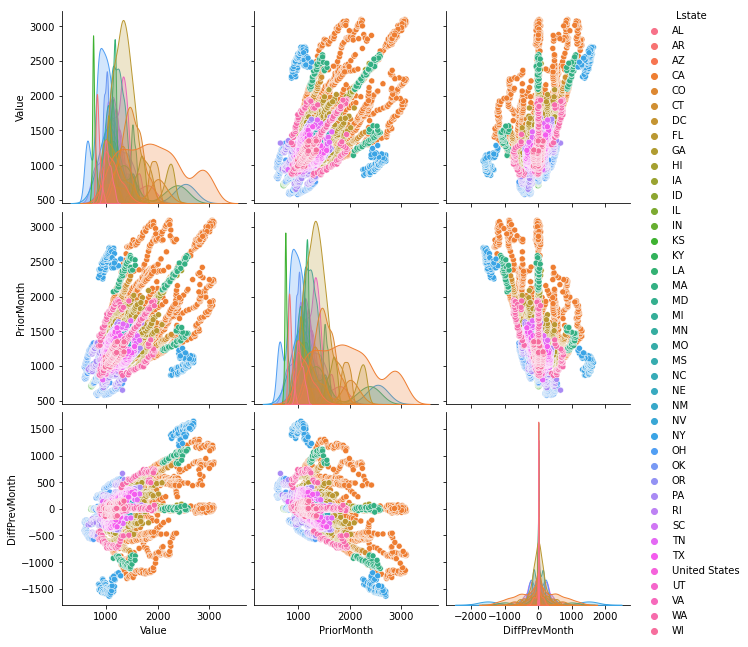

In [71]:
# The diagonal elements in a pairplot show the histogram by default
# We can update these elements to show other things, such as a kde

sns.pairplot(RentalRates_Window, hue='Lstate', height=3, diag_kind='kde')

array([[<AxesSubplot:title={'center':'DiffPrevMonth'}, xlabel='[Lstate]'>,
        <AxesSubplot:title={'center':'PriorMonth'}, xlabel='[Lstate]'>],
       [<AxesSubplot:title={'center':'Value'}, xlabel='[Lstate]'>,
        <AxesSubplot:>]], dtype=object)

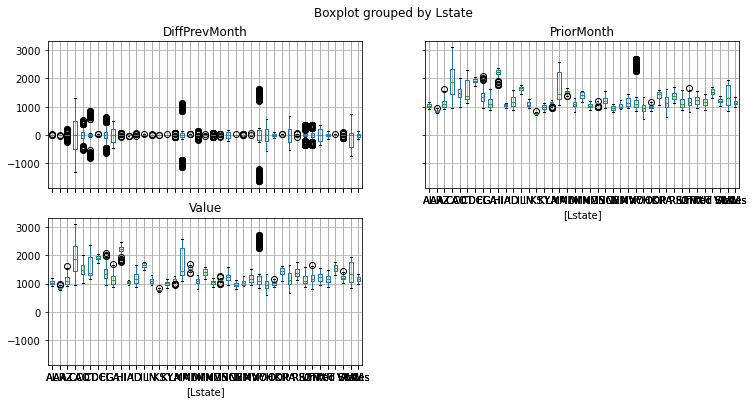

In [73]:
# make a boxplot with Pandas on each feature split out by Lstate

RentalRates_Window.boxplot(by='Lstate', figsize=(12,6))

In [78]:
cnxn.close()